# Semantic Image Segmentation on CityScapes Dataset using U-Net Archtitecture

##### *Luciano Deben   1440705*
---

## Import Libraries

In [11]:
# Importing the libraries        
import torch
import torch.nn as nn
from torchvision.datasets import Cityscapes
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm
import keras

## Data Preprocessing

In [12]:
# Global variables
DATA_PATH = "../data/CityScapes/"
BATCH_SIZE = 2
NUM_WORKERS = 1

def get_data_loader(batch_size, num_workers):
    # Define the transform for the images
    transform = v2.Compose([
        v2.Resize((256, 256)),  
        v2.PILToTensor(), 
        v2.ToDtype(torch.float32),
        v2.Normalize((0, 0, 0), (1, 1, 1))
    ])
    # Define the transform for the labels
    target_transform = v2.Compose([
        v2.Resize((256, 256), interpolation=0),
        v2.PILToTensor(), 
        v2.ToDtype(torch.float32)
    ])

    # Load the dataset
    dataset = Cityscapes(DATA_PATH, split='train', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)
    
    # Define the size of the validation set
    val_size = int(0.1 * len(dataset))
    train_size = len(dataset) - val_size

    # Split the dataset
    train_subset, val_subset = random_split(dataset, [train_size, val_size])

    # Define the data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader


In [13]:
# Instantiate the data loaders
train_loader, val_loader = get_data_loader(BATCH_SIZE, NUM_WORKERS)

In [14]:
# Get a batch of training and validation data
inputs, targets = next(iter(train_loader))
val_inputs, val_targets = next(iter(val_loader))

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


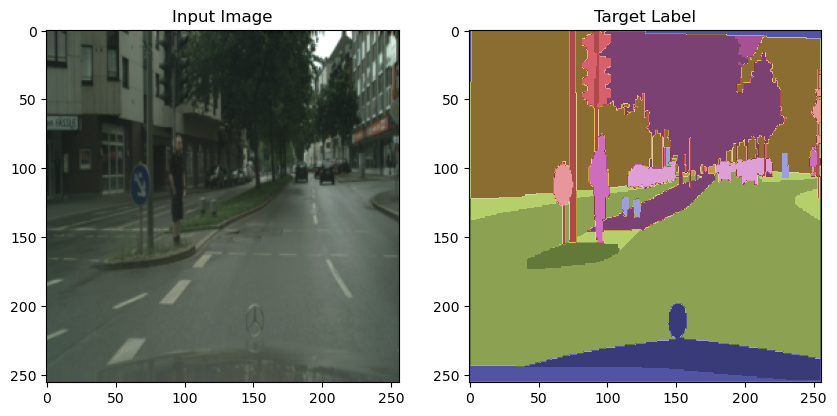

tensor([[[ 3.,  3.,  3.,  ...,  3.,  3.,  3.],
         [ 3.,  2., 11.,  ...,  2.,  2.,  3.],
         [ 3.,  2., 11.,  ...,  2.,  2.,  3.],
         ...,
         [ 3.,  2.,  2.,  ...,  1.,  1.,  3.],
         [ 3.,  2.,  2.,  ...,  1.,  1.,  3.],
         [ 3.,  3.,  3.,  ...,  3.,  3.,  3.]]])


In [15]:
# Check the size of the data
exp_input = inputs[0]
exp_target = targets[0]
print(exp_input.size(), exp_target.size())

# Normalize the image to the range [0, 1]
exp_input_normalized = (exp_input - exp_input.min()) / (exp_input.max() - exp_input.min())

# Plot the examples
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(exp_input_normalized.permute(1, 2, 0))
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(exp_target.squeeze(), cmap='tab20b')
plt.title("Target Label")
plt.show()

print(exp_target)

## Model Building

In [16]:
# Define U-Net Segmentation Model

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 34, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Segmentation output """
        outputs = self.outputs(d4)

        return outputs


class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

        # Apply He initialization
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [17]:
print(torch.cuda.is_available())

True


## Model Training

In [8]:
# Define metric functions
    
def pixel_accuracy(output, target):
    output = torch.argmax(output, dim=1)
    correct = torch.eq(output, target).float()
    return correct.sum() / correct.numel()

def dice_coefficient(output, target):
    smooth = 1e-6
    output = torch.argmax(output, dim=1).long()  # Convert to long tensor
    target = target.squeeze(1).long()  # Convert to long tensor

    intersection = (output * target).sum()
    dice = (2. * intersection + smooth) / (output.sum() + target.sum() + smooth)

    return dice

In [18]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move your model to the device
model = Model().to(device)

print(inputs.size())
print(model(inputs.to(device)).size())

# Define the loss function
criterion = nn.CrossEntropyLoss(ignore_index=255)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Define the number of epochs
n_epochs = 3

def train(train_dataloader, model, criterion, optimizer, device):
    model.train()
    train_loss = 0
    train_acc = 0
    train_dice = 0
    for inputs, targets in tqdm(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze(1).long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += pixel_accuracy(outputs, targets).item()
        train_dice += dice_coefficient(outputs, targets).item()
        outputs = torch.argmax(outputs, dim=1)

    return train_loss / len(train_dataloader), train_acc / len(train_dataloader), train_dice / len(train_dataloader)

def validate(val_dataloader, model, criterion, device):
    model.eval()
    val_loss = 0
    val_acc = 0
    val_dice = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze(1).long())

            val_loss += loss.item()
            val_acc += pixel_accuracy(outputs, targets).item()
            val_dice += dice_coefficient(outputs, targets).item()
            outputs = torch.argmax(outputs, dim=1)

    return val_loss / len(val_dataloader), val_acc / len(val_dataloader), val_dice / len(val_dataloader)

torch.Size([2, 3, 256, 256])
torch.Size([2, 34, 256, 256])


In [17]:
# Training loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dices = []
val_dices = []

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss, train_acc, train_dice = train(train_loader, model, criterion, optimizer, device)
    val_loss, val_acc, val_dice = validate(val_loader, model, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    
    print(f"Train Loss: {train_loss:.4f}, Train IOU: {mean_iou_train.result():.4f}, Train Acc: {train_acc:.4f}, Train Dice: {train_dice:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val IOU: {mean_iou_val.result()}, Val Acc: {val_acc:.4f}, Val Dice: {val_dice:.4f}")
    scheduler.step()

Epoch 1
-------------------------------


100%|██████████| 14/14 [00:06<00:00,  2.01it/s]


Train Loss: 1.5454, Train IOU: 0.1064, Train Acc: 0.5539, Train Dice: 14.7404
Val Loss: 0.9569, Val IOU: 0.18372346460819244, Val Acc: 0.6435, Val Dice: 15.3612
Epoch 2
-------------------------------


100%|██████████| 14/14 [00:07<00:00,  1.89it/s]


Train Loss: 0.9915, Train IOU: 0.1272, Train Acc: 0.6053, Train Dice: 14.9538
Val Loss: 0.7847, Val IOU: 0.19294388592243195, Val Acc: 0.6792, Val Dice: 15.1912
Epoch 3
-------------------------------


100%|██████████| 14/14 [00:07<00:00,  1.90it/s]

Train Loss: 0.9039, Train IOU: 0.1376, Train Acc: 0.6162, Train Dice: 15.0391
Val Loss: 0.8214, Val IOU: 0.19534634053707123, Val Acc: 0.6506, Val Dice: 15.9018


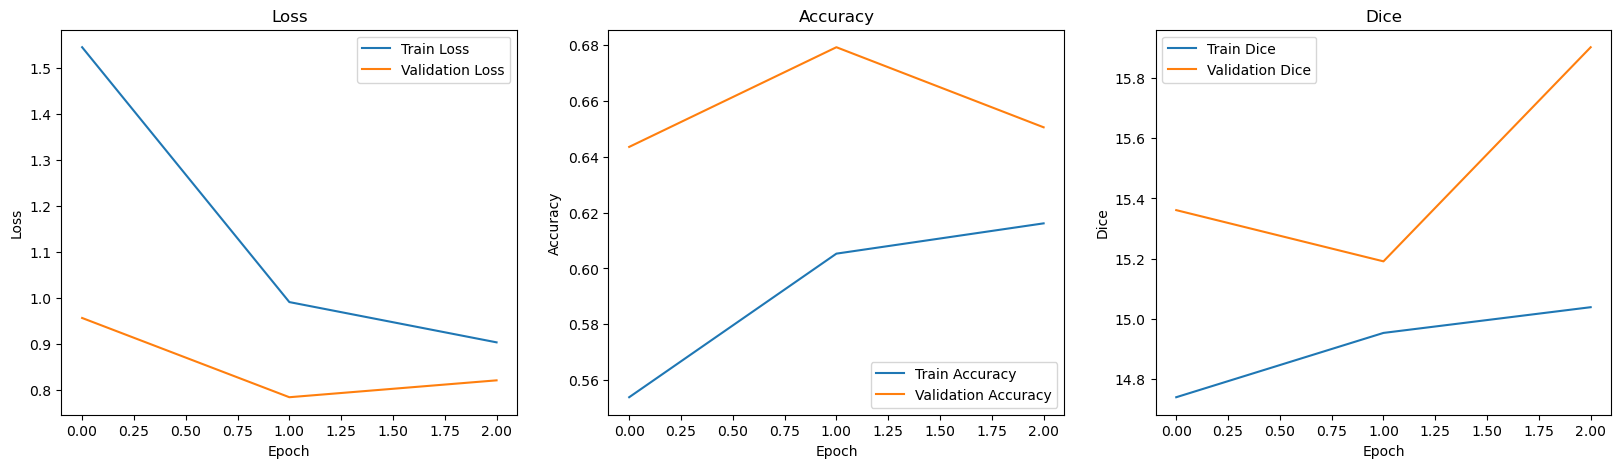

In [21]:
# Plot the training and validation metrics
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.title('Dice')

plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), "unet-model.pth")

## Hyperparameter Tuning

## Model Evaluation

## Load Pre-trained model

In [8]:
# Load the model checkpoint
checkpoint = torch.load('../models/mask2former_internimage_h_896_80k_cocostuff2ade20k.pth')
model.load_state_dict(checkpoint)

# Put the model in evaluation mode
model.eval()

# Initialize lists to store targets and outputs
all_targets = []
all_outputs = []

# Iterate over the test loader
for inputs, targets in val_loader:
    # Move data to the appropriate device
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)

    # Store targets and outputs
    all_targets.append(targets.cpu().numpy())
    all_outputs.append(outputs.cpu().numpy())

# Now you can use all_targets and all_outputs for further evaluation

NameError: name 'model' is not defined